In [100]:
#Importamos las librerías
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob

Aquí sería donde descomprimo el dataset, pero como estoy usando jupyter, debo borrar la carpeta (si existe) y volver a descomprimirla. Luego veremos por qué es necesario borrar la carpeta cada vez que ejecutemos el cuaderno

In [101]:
import shutil
import zipfile
import os

def eliminar_carpetas(carpeta):
    if os.path.exists(carpeta):
        shutil.rmtree(carpeta)
        print(f"Carpeta '{carpeta}' eliminada.")
    else:
        print(f"La carpeta '{carpeta}' no existe.")

def extraer_zip(archivo_zip, destino):
    with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
        zip_ref.extractall(destino)
        print(f"Archivo '{archivo_zip}' extraído en '{destino}'.")

# Ejemplo de uso
carpeta_a_eliminar = 'ruta/a/tu/carpeta'
archivo_zip = 'ruta/a/tu/archivo.zip'
destino_extraccion = 'ruta/a/tu/destino'

eliminar_carpetas("Chessman-image-dataset")
extraer_zip("archive.zip", ".")


Carpeta 'Chessman-image-dataset' eliminada.
Archivo 'archive.zip' extraído en '.'.


In [102]:
#Hacemos una relación entre los nombres de las imágenes y las clases
MAP_CHARACTERS = { 0: 'Bishop', 1: 'King', 2: 'Knight', 3: 'Pawn', 4: 'Queen', 5: 'Rook' }
# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

Declaramos dos funciones para cargar los datos. Una dedicada a la fracción train y la otra para test

In [103]:
def load_train_set(dirname, map_characters, verbose=True):
	"""Esta función carga los datos de training en imágenes.

	Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
	para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

	Args:
		dirname: directorio completo del que leer los datos
		map_characters: variable de mapeo entre labels y personajes
		verbose: si es True, muestra información de las imágenes cargadas

	Returns:
		X, y: X es un array con todas las imágenes cargadas con tamaño
	IMG SIZE x IMG SIZE
				y es un array con las labels de correspondientes a cada imagen
	"""
	X_train = []
	y_train = []
	for label, character in map_characters.items():        
		files = os.listdir(os.path.join(dirname, character))
		images = [file for file in files if file.endswith("jpg")]
		if verbose:
			print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
		for image_name in images:
			image = cv2.imread(os.path.join(dirname, character, image_name))
			X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
			y_train.append(label)
	return np.array(X_train), np.array(y_train)

def load_test_set(dirname, map_characters, verbose=True):
   """Esta función funciona de manera equivalente a la función load_train_set
   pero cargando los datos de test."""
   X_test = []
   y_test = []
   reverse_dict = {v: k for k, v in map_characters.items()}
   for filename in glob.glob(dirname + '/*.*'):
       char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
       if char_name in reverse_dict:
           image = cv2.imread(filename)
           image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
           X_test.append(image)
           y_test.append(reverse_dict[char_name])
   if verbose:
       print("Leídas {} imágenes de test".format(len(X_test)))
   return np.array(X_test), np.array(y_test)
   

Uso esta función para dividir el dataset en train y test

In [104]:
import shutil
from sklearn.model_selection import train_test_split


def split_dataset(source_dir, dest_dir, split_ratio=0.3):
	"""
	Esta función divide el dataset en dos partes, una para training y otra para test, y lo pone en directorios distintos.
	"""
	if not os.path.exists(dest_dir):
		os.makedirs(dest_dir)
	
	for character in os.listdir(source_dir):
		character_path = os.path.join(source_dir, character)
		if os.path.isdir(character_path):
			images = [file for file in os.listdir(character_path) if file.endswith("jpg")]
			train_images, test_images = train_test_split(images, test_size=split_ratio, random_state=42)
			
			character_dest_path = os.path.join(dest_dir, character)
			if not os.path.exists(character_dest_path):
				os.makedirs(character_dest_path)
			
			for image in test_images:
				shutil.move(os.path.join(character_path, image), os.path.join(character_dest_path, image))

source_directory = ".\\Chessman-image-dataset\\Chess"
destination_directory = ".\\Chessman-image-dataset\\Chess_test"
split_dataset(source_directory, destination_directory)

In [105]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = ".\\Chessman-image-dataset\\Chess"
DATASET_TEST_PATH_COLAB = "Chessman-image-dataset\\Chess_test"
X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)
X = X / 255.0
X_t = X_t / 255.0
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

Leyendo 49 imágenes encontradas de Bishop
Leyendo 42 imágenes encontradas de King
Leyendo 65 imágenes encontradas de Knight
Leyendo 60 imágenes encontradas de Pawn
Leyendo 46 imágenes encontradas de Queen
Leyendo 60 imágenes encontradas de Rook
Leídas 0 imágenes de test


In [106]:
from sklearn.model_selection import train_test_split

# Separamos los datos en training y validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (257, 64, 64, 3)
Validation data shape: (65, 64, 64, 3)


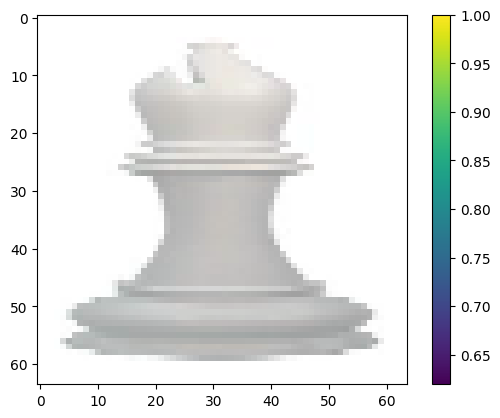

Bishop
(64, 64, 3)


In [107]:
 #Declaramos una función para visualizar las imágenes
def visualize_example(x):
	plt.figure()
	plt.imshow(x)
	plt.colorbar()
	plt.grid(False)
	plt.show()
visualize_example(X[70]) # Visualiza la imagen normalizada con valores de 0 a 1
print(MAP_CHARACTERS[y[70]]) # Acceso al diccionario
print(X[70].shape[0:3]) # Dimensiones de la imagen tras resize con los 3 canales RGB

In [108]:
#batch_size=128
num_classes=18
epochs=5
img_rows,img_cols=IMG_SIZE,IMG_SIZE
input_shape=(img_rows,img_cols,3) #(64,64,3)
# convert class vectors to binary class matrices
y=keras.utils.to_categorical(y,num_classes)
y_t=keras.utils.to_categorical(y_t,num_classes)

X.shape

(322, 64, 64, 3)

In [109]:
y.shape

(322, 18)

In [110]:
filters = 32  # Example value for filters
kernel_size = (3, 3)  # Example value for kernel_size

conv_layer = keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)

In [111]:
model = keras.Sequential([
keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last",input_shape=(64, 64, 3), activation='relu'),
keras.layers.MaxPooling2D(pool_size=(2, 2)),
keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
keras.layers.MaxPooling2D(pool_size=(2, 2)),
keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
keras.layers.MaxPooling2D(pool_size=(2, 2)),
keras.layers.MaxPooling2D(pool_size=(2, 2)),
keras.layers.Flatten(),
keras.layers.Dense(500, activation='relu'),
keras.layers.Dropout(0.5),
keras.layers.Dense(18, activation='softmax')
])
model.summary()
model.compile(optimizer='adam',
loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\Javier\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     2,304,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         9,018 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,941,742 (11.22 MB)

 Trainable params: 2,941,742 (11.22 MB)

 Non-trainable params: 0 (0.00 B)